# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.


Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

In [2]:
geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [3]:
#функция принимает в качестве обязательного аргумента датасет
#необязательные  аргументы xlim_hist, bins, xlim_box, feature

#xlim_hist - список из двух элементов, мин и мах значения интервала, на котором будет построена гистограмма. 
#Пример: xlim_hist = [0,100]

#bins - число интервалов разбиения для гистограммы(корзин). Пример bins = 50 (значение по умолчанию)

#xlim_box интервал построения диаграммы размаха. Пример xlim_box = [100,1000] От 100 до 1000

#feature. По умолчанию = 0. Если не указывать feature, то функция построит графики сразу для всех числовых столбцов.
#c  помощью параметра feature можно построить график только для конткретного признака, указав его название в виде строки

def plot_hist_and_boxplot(dataset, feature=0, xlim_hist=0, bins=50, xlim_box=0):
    
    if feature  == 0:
        for col in dataset.select_dtypes(exclude = 'object').columns:
            feature = dataset[col]

            print("\033[4m"+ f'Основные числовые характеристики столбца {feature.name}:' + "\033[0m")

            print(feature.describe())
    
            plt.figure(figsize=(18,7))
            plt.subplot(1,2,1)
            plt.hist(x = feature, bins=bins, color='lightblue', edgecolor = 'black', )
            plt.grid()
            plt.title(f'Гистограмма частот для {feature.name}')
            plt.ylabel('частоты')
            plt.xlabel(feature.name)
    
            if xlim_hist != 0:
                plt.xlim(xlim_hist[0], xlim_hist[1])
    
    
            plt.subplot(1, 2, 2)
            plt.boxplot(feature, vert=False)
            plt.title(f'Диаграмма размаха для {feature.name}')
            plt.xlabel(feature.name)
            plt.grid()
            if xlim_box != 0:
                plt.xlim(xlim_box[0], xlim_box[1])
            plt.show()
            print('-'*110)
            print()
            
    else:
        if feature in dataset.columns:
            feature = dataset[feature]
            print("\033[4m"+ f'Основные числовые характеристики столбца {feature.name}:' + "\033[0m")

            print(feature.describe())
            plt.figure(figsize=(18,7))
            plt.subplot(1,2,1)
            plt.hist(x = feature, bins=bins, color='lightblue', edgecolor = 'black', )
            plt.grid()
            plt.title(f'Гистограмма частот для {feature.name}')
            plt.ylabel('частоты')
            plt.xlabel(feature.name)
    
            if xlim_hist != 0:
                plt.xlim(xlim_hist[0], xlim_hist[1])
    
    
            plt.subplot(1, 2, 2)
            plt.boxplot(feature, vert=False)
            plt.title(f'Диаграмма размаха для {feature.name}')
            plt.xlabel(feature.name)
            plt.grid()
            if xlim_box != 0:
                plt.xlim(xlim_box[0], xlim_box[1])
            plt.show()
            print('-'*110)
            print()
            
        else:
            print(f'ОШИБКА! ПРИЗНАКА {feature} НЕТ СРЕДИ СТОЛБЦОВ УКАЗАННОГО ДАТАСЕТА!')

### Предобработка

#### Предобработка `geo_data_0`

In [4]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков нет, типы данных столбцов соответсвуют содержанию

In [6]:
geo_data_0.duplicated().sum()

0

Полных дупликатов нет. Проверим на предмет повторений уникальные id

In [7]:
sum(geo_data_0['id'].value_counts() > 1)

10

10 уникальных id скважины встречается в датасете больше одного раза

In [8]:
geo_data_0[geo_data_0.duplicated(['id'], keep = False)].sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


В датасете по нулевому региону нашлось 10 скважин, упомянутых по два раза, при этом с разными значениями признаков. Может какие-то данные новые, какие-то старые. Трудно что-либо предположить, не зная смысл признаков f0 f1 f2. Проще эти скважины удалить

In [9]:
delete_list = geo_data_0[geo_data_0.duplicated('id')]['id'].to_list()
geo_data_0 = geo_data_0.query('id not in @delete_list')
geo_data_0.shape

(99980, 5)

In [10]:
geo_data_0.duplicated('id').sum()

0

Повторяющихся `id` не осталось. 

#### Предобработка `geo_data_1`

In [11]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [12]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков нет, типы данных столбцов соответсвуют содержанию|

In [13]:
geo_data_1.duplicated().sum()

0

Полных дупликатов нет, посмотрим есть ли повторы среди уникальных `id`

In [14]:
geo_data_1.duplicated('id').sum()

4

In [15]:
geo_data_1[geo_data_1.duplicated(['id'], keep = False)].sort_values(by='id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


**Здесь такая же ситуация с `id` скважин. Непонятно какие записи верны, а какие нет. Лучше удалить эти скважины вовсе**

In [16]:
geo_data_1.drop_duplicates(subset= ['id'], keep= False, inplace = True )
geo_data_1.shape

(99992, 5)

In [17]:
geo_data_1.duplicated('id').sum()

0

Повторяющихся `id` не осталось. 

#### Предобработка `geo_data_2`

In [18]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [19]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков нет, типы данных столбцов соответсвуют содержанию|

In [20]:
geo_data_2.duplicated().sum()

0

Полных дупликатов нет, посмотрим есть ли повторы среди уникальных `id`

In [21]:
geo_data_2.duplicated('id').sum()

4

In [22]:
geo_data_2[geo_data_2.duplicated(['id'], keep = False)].sort_values(by='id')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


**Здесь такая же ситуация с `id` скважин. Непонятно какие записи верны, а какие нет. Лучше удалить эти скважины вовсе**

In [23]:
geo_data_2.drop_duplicates(subset= ['id'], keep= False, inplace = True )
geo_data_2.shape

(99992, 5)

In [24]:
geo_data_2.duplicated('id').sum()

0

Повторяющихся `id` не осталось. 

**Сделаем `id` скважин индексами во всех трех датасетах**

In [25]:
geo_data_0 = geo_data_0.set_index('id')
geo_data_1 = geo_data_1.set_index('id')
geo_data_2 = geo_data_2.set_index('id')


**Вывод по разделу `Предобработка`**

Данные считались корректно, типы данных соответсвуют содержанию столбцов. Пропусков нет. Полных дупликатов нет. Были обнаружены повторяющиеся id скважин, все скважины, id которых встречалось больше одного раза были удалены

### Исследовательский анализ

#### Исследовательский анализ `geo_data_0`

In [26]:
geo_data_0.head()

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


Основные числовые характеристики столбца f0:
count    99980.000000
mean         0.500447
std          0.871879
min         -1.408605
25%         -0.072674
50%          0.502374
75%          1.073692
max          2.362331
Name: f0, dtype: float64


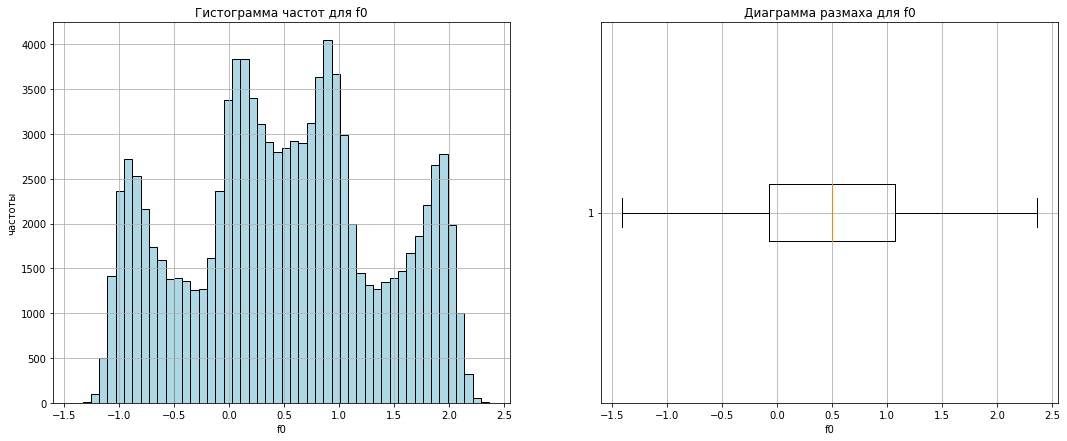

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца f1:
count    99980.000000
mean         0.250147
std          0.504431
min         -0.848218
25%         -0.200869
50%          0.250252
75%          0.700646
max          1.343769
Name: f1, dtype: float64


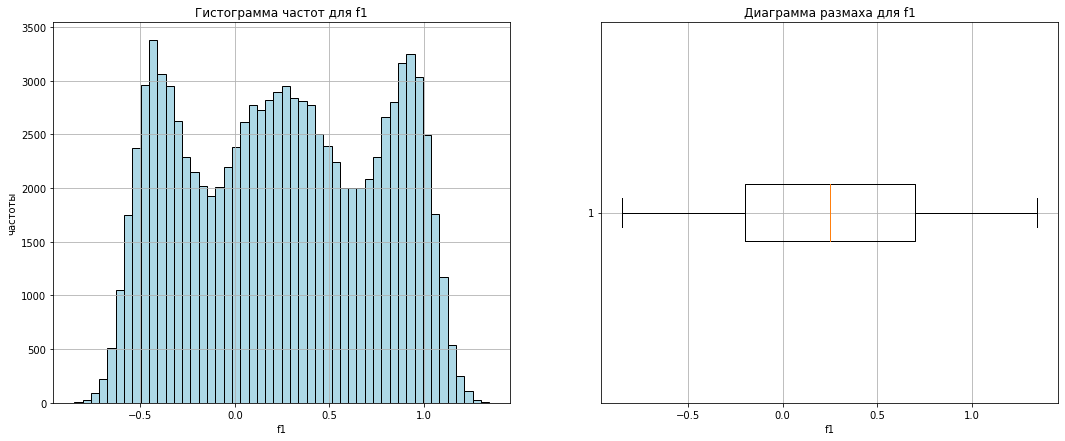

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца f2:
count    99980.000000
mean         2.502638
std          3.248056
min        -12.088328
25%          0.288010
50%          2.516005
75%          4.714884
max         16.003790
Name: f2, dtype: float64


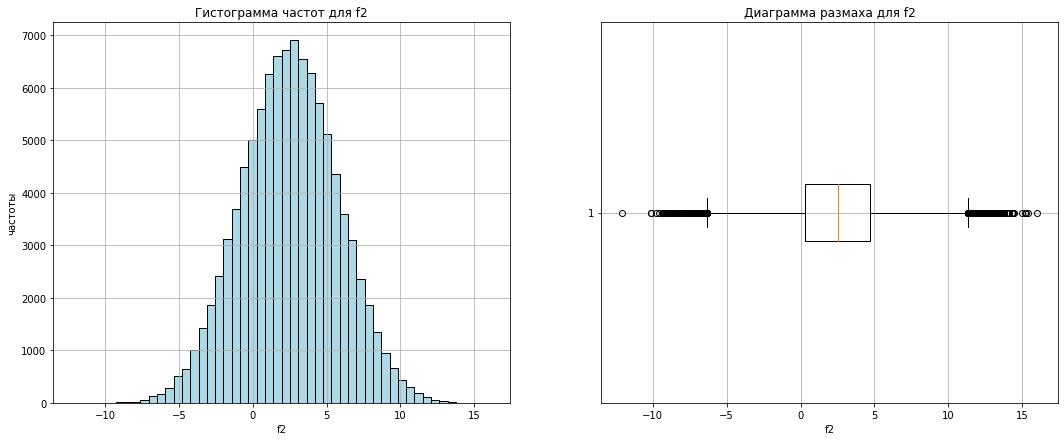

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца product:
count    99980.000000
mean        92.499166
std         44.289044
min          0.000000
25%         56.496513
50%         91.847928
75%        128.564089
max        185.364347
Name: product, dtype: float64


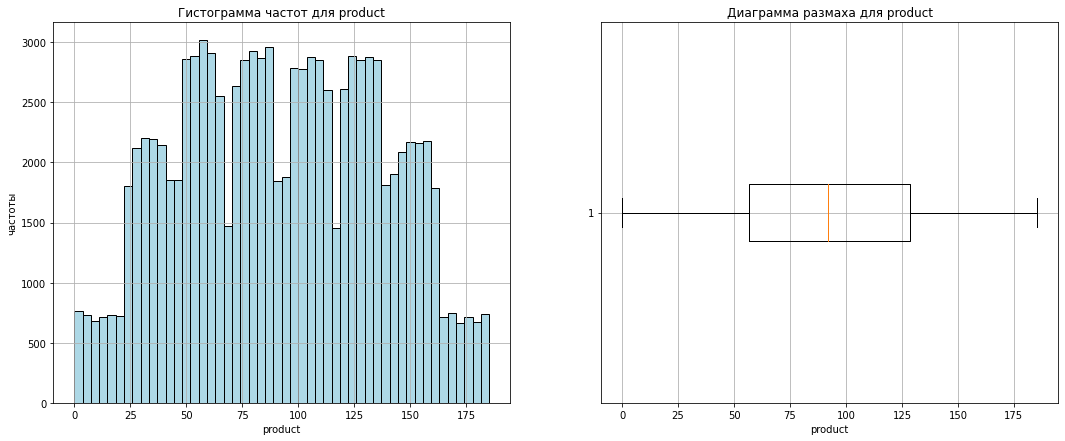

--------------------------------------------------------------------------------------------------------------



In [27]:
plot_hist_and_boxplot(geo_data_0)

Только признак `f2` имеет нормальное распределение. Остальные признаки имеют довольно необычные распределения

In [28]:
geo_data_0[geo_data_0['product'] <= 0]

,f0,f1,f2,product
id,,,,
zCM5W,-0.702064,0.375992,0.236572,0.0


Есть одна сважина, не дающая вообще ничего. Может она только находится в разработке и не готова к работе. В датасете есть и другие скважины с близкими к нулю значениями `product`, но нулевое значение одно единственное. Зато в датасете региона 1 скважин с нулевым `product` около 8тыс, так что удалять эту скважину не буду

Теперь посмотрим на числовые характеристики

In [29]:
geo_data_0.describe()

,f0,f1,f2,product
count,99980.000000,99980.000000,99980.000000,99980.000000
mean,0.500447,0.250147,2.502638,92.499166
std,0.871879,0.504431,3.248056,44.289044
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072674,-0.200869,0.288010,56.496513
50%,0.502374,0.250252,2.516005,91.847928
75%,1.073692,0.700646,4.714884,128.564089
max,2.362331,1.343769,16.003790,185.364347


Признаки имеют разный масштаб. При обучении модели возможно нужно будет применить масштабирование

#### Исследовательский анализ `geo_data_1`

In [30]:
geo_data_1.head()

,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


Основные числовые характеристики столбца f0:
count    99992.000000
mean         1.141363
std          8.965805
min        -31.609576
25%         -6.298525
50%          1.153190
75%          8.620964
max         29.421755
Name: f0, dtype: float64


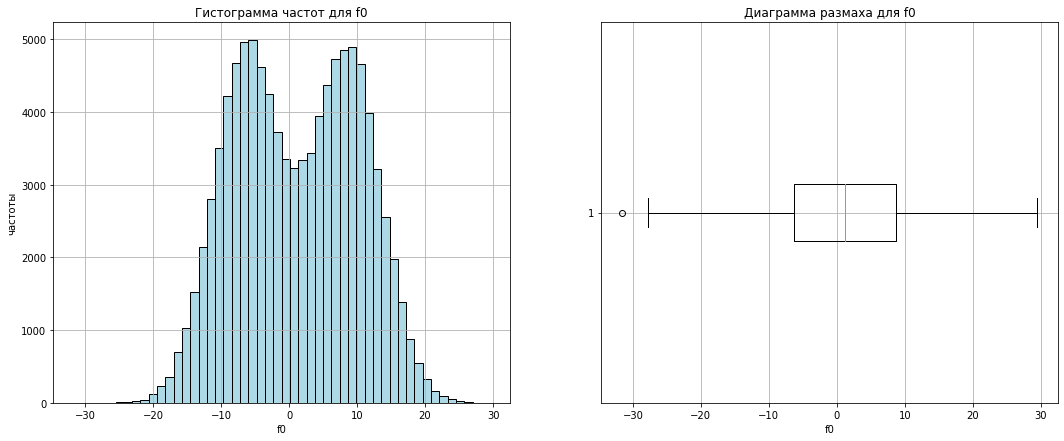

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца f1:
count    99992.000000
mean        -4.796522
std          5.119934
min        -26.358598
25%         -8.267985
50%         -4.813005
75%         -1.332704
max         18.734063
Name: f1, dtype: float64


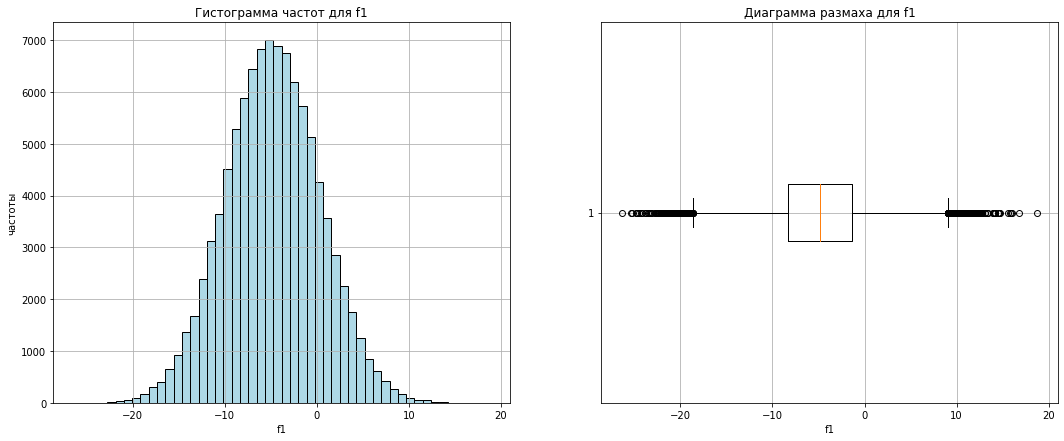

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца f2:
count    99992.000000
mean         2.494511
std          1.703587
min         -0.018144
25%          1.000021
50%          2.011475
75%          3.999904
max          5.019721
Name: f2, dtype: float64


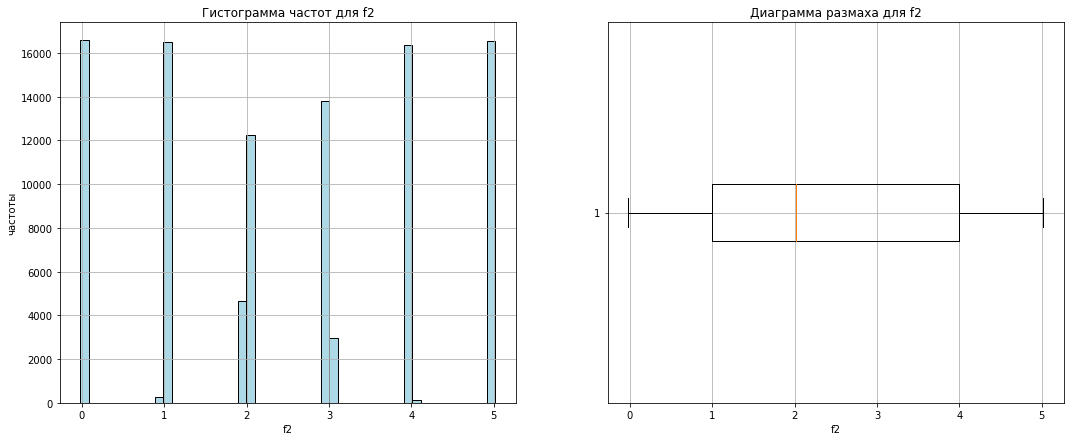

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца product:
count    99992.000000
mean        68.824148
std         45.944889
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64


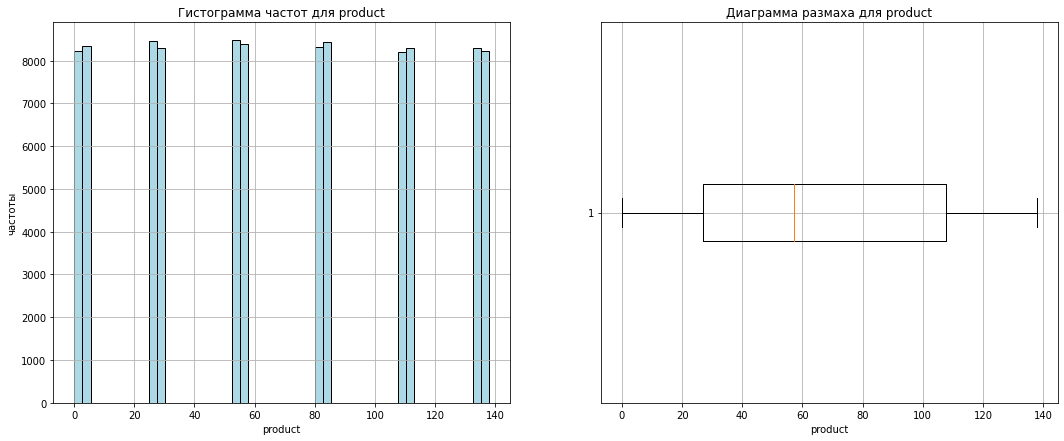

--------------------------------------------------------------------------------------------------------------



In [31]:
plot_hist_and_boxplot(geo_data_1)

В датасете по 1 региону наблюдаются совсем другие распределения по всем признакам. `f1` теперь распределен нормально, а `f2` - нет. `f2` и  `product` теперь стали носить дискретный характер

In [32]:
geo_data_1[geo_data_1['product'] <= 0]

,f0,f1,f2,product
id,,,,
OXyvW,16.320755,-0.562946,-0.001783,0.0
igmai,6.695604,-0.749449,-0.007630,0.0
Qjy5w,21.418478,-5.134490,-0.002836,0.0
G6WCj,6.822701,3.104979,-0.000723,0.0
MzQhL,6.750150,-11.893512,-0.001601,0.0
...,...,...,...,...
YrRU8,5.085749,-3.980305,0.005063,0.0
Jbnur,8.277805,-9.178818,0.003275,0.0
aV1cJ,13.343983,-1.290200,0.005980,0.0


Те самые 8тыс скважин региона 1, имеющие нулевую отдачу.

Числовые характеристики:

In [33]:
geo_data_1.describe()

,f0,f1,f2,product
count,99992.000000,99992.000000,99992.000000,99992.000000
mean,1.141363,-4.796522,2.494511,68.824148
std,8.965805,5.119934,1.703587,45.944889
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298525,-8.267985,1.000021,26.953261
50%,1.153190,-4.813005,2.011475,57.085625
75%,8.620964,-1.332704,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Масштаб данных тоже разный, потребуется масштабирование

#### Исследовательский анализ `geo_data_2`

In [34]:
geo_data_2.head()

,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


Основные числовые характеристики столбца f0:
count    99992.000000
mean         0.001975
std          1.732061
min         -8.760004
25%         -1.162328
50%          0.009411
75%          1.158442
max          7.238262
Name: f0, dtype: float64


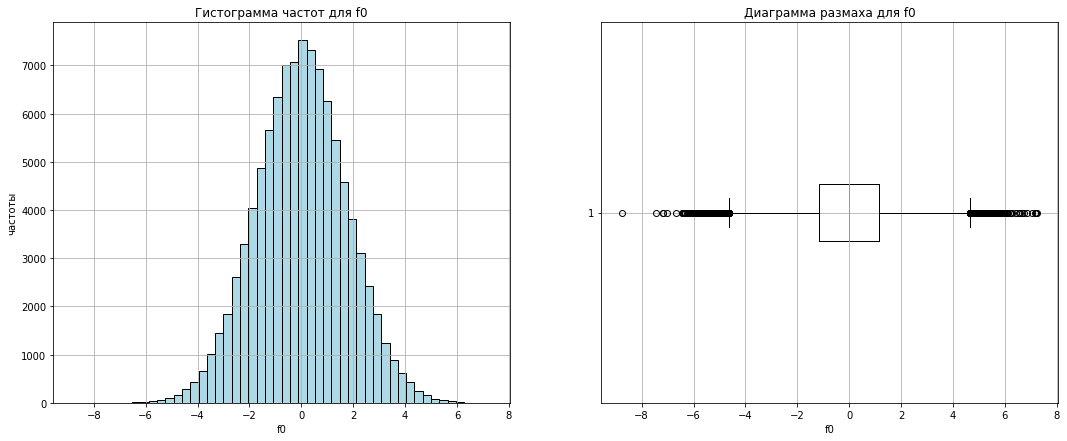

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца f1:
count    99992.000000
mean        -0.002113
std          1.730404
min         -7.084020
25%         -1.174820
50%         -0.009580
75%          1.163592
max          7.844801
Name: f1, dtype: float64


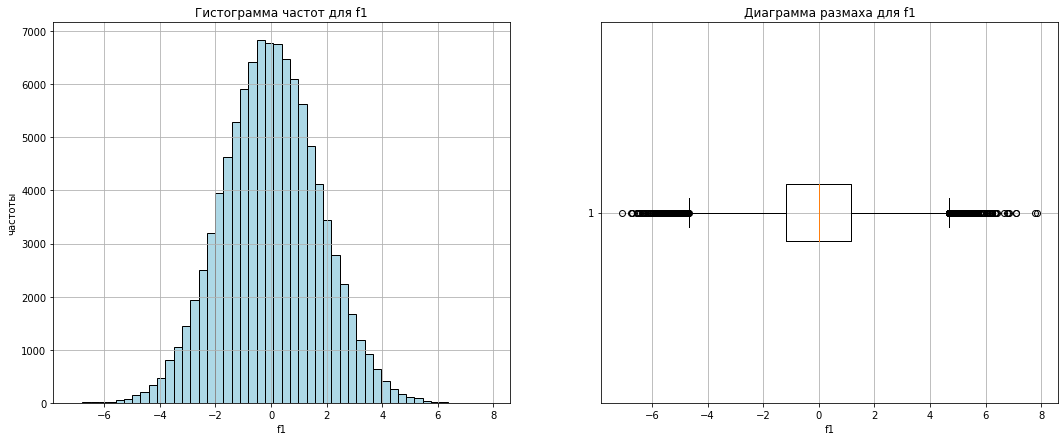

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца f2:
count    99992.000000
mean         2.495088
std          3.473491
min        -11.970335
25%          0.130269
50%          2.484236
75%          4.858662
max         16.739402
Name: f2, dtype: float64


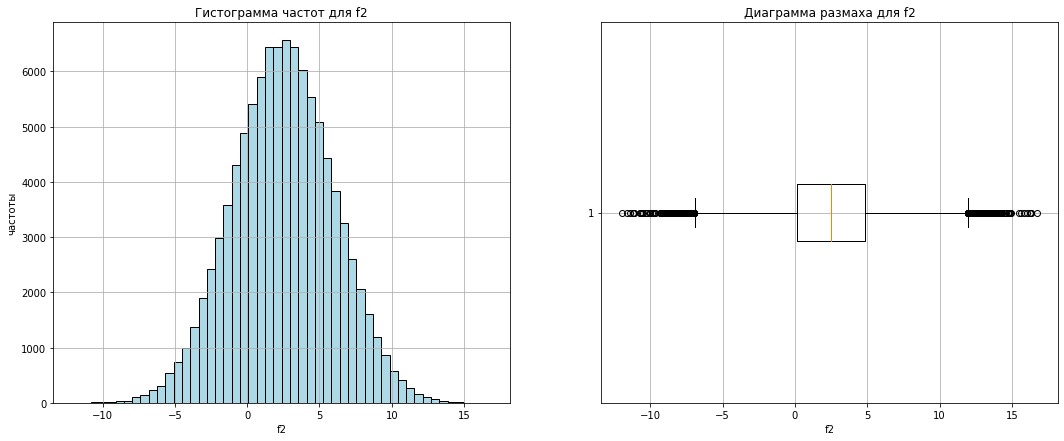

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца product:
count    99992.000000
mean        94.998767
std         44.747763
min          0.000000
25%         59.450441
50%         94.925026
75%        130.585544
max        190.029838
Name: product, dtype: float64


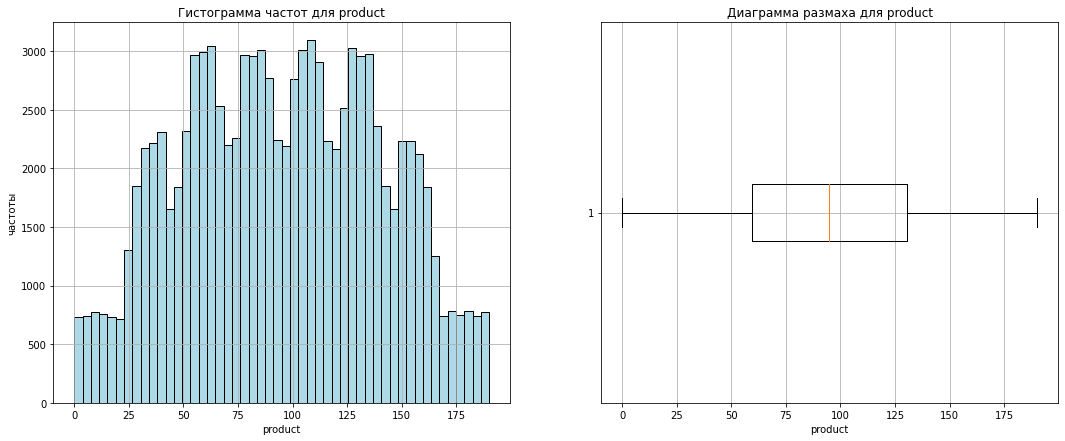

--------------------------------------------------------------------------------------------------------------



In [35]:
plot_hist_and_boxplot(geo_data_2)

В 3 регионе все три признака `f0`, `f1`, `f2` имеют нормальное распределение, но смещены относительно друг друга.

Числовые характеристики:

In [36]:
geo_data_2.describe()

,f0,f1,f2,product
count,99992.000000,99992.000000,99992.000000,99992.000000
mean,0.001975,-0.002113,2.495088,94.998767
std,1.732061,1.730404,3.473491,44.747763
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174820,0.130269,59.450441
50%,0.009411,-0.009580,2.484236,94.925026
75%,1.158442,1.163592,4.858662,130.585544
max,7.238262,7.844801,16.739402,190.029838


Признаки `f0`,`f1` очень похожи по числовым характерстикам. Признак `f2` отличается. Здесь тоже потребуется масштабирование

**Вывод по разделу `Исследовательский анализ`**

Распределения признаков меняются от датасета к датасету. Где-то один признак может быть распределен нормально, а где-то иметь нестандартное распределение. Большинство признаков имеет нестандартное распределение. Есть признаки, которые для одного региона носят непрерывный характер, а для другуго дискретный


В регионе 1 имеются около 8тыс скважин с нулевой отдачей

### Корреляционный анализ

#### Корреляционный анализ `geo_data_0`

Посмотрим на матрицу корреляции для региона 0. Поскольку есть признаки имеющие распределение отличное от нормального, будем считать корреляцию Спирмана:

In [37]:
geo_data_0.corr(method='spearman').style.background_gradient(cmap = 'coolwarm')

,f0,f1,f2,product
f0,1.000000,-0.471381,-0.002731,0.128382
f1,-0.471381,1.000000,0.001441,-0.181124
f2,-0.002731,0.001441,1.000000,0.486372
product,0.128382,-0.181124,0.486372,1.000000


Все возможные пары признаков коррелируют между собой либо слабо, либо очень слабо, согласно шкале Чеддока. Отсутвие корреляции между признаками хороший знак для модели линейной регрессии. Однако слабая корреляция целевого признака `product` c входными признаками `f0`, `f1` и `f2` наоборот не является положительным фактором для модели. Самая высокая корреляция у `product` с входным признаком `f2` - (0.49)

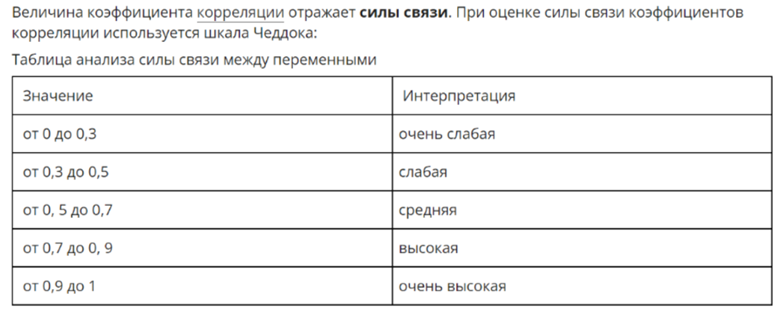

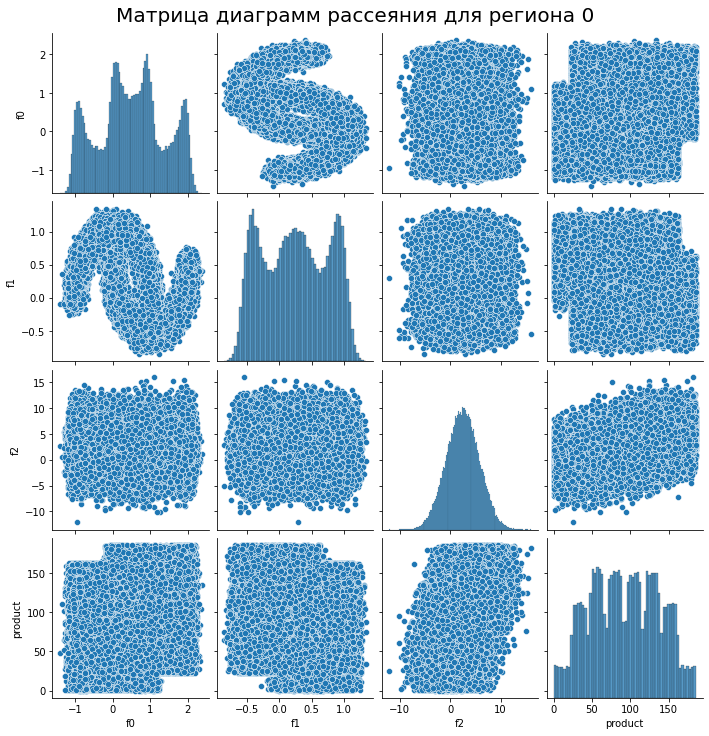

In [38]:
g = sns.pairplot(geo_data_0, palette=('#FFFF00', '#800080'))
g.fig.suptitle('Матрица диаграмм рассеяния для региона 0', y=1.02, fontsize= 20)
plt.show()

- Действительно на диаграммах рассеяния отчетливо видна положительная связь между целевым признаком `product` и входным `f2`
- Некоторые пары признаков имеют странные диаграммы рассеяния. Странность заключается в явной симметричности рисунка, образованного точками на диаграммме рассеяния. Например это наблюдение характерно для пары `product` и `f1`. На рисунке даже видны четкие прямые углы
- Еще один интересный рисунок имеет диаграмма рассеяния признаков `f1` и `f0`
- Такие правильные красивые формы на диагрммах рассеяния для меня в новинку. Но, к сожалению, природа признаков `f0`, `f1` и `f2` нам неизвестна

#### Корреляционный анализ `geo_data_1`

In [39]:
geo_data_1.corr(method='spearman').style.background_gradient(cmap = 'coolwarm')

,f0,f1,f2,product
f0,1.000000,0.182227,-0.002036,-0.122912
f1,0.182227,1.000000,-0.003692,-0.033919
f2,-0.002036,-0.003692,1.000000,0.975604
product,-0.122912,-0.033919,0.975604,1.000000


Здесь целевой признак `product` наиболее коррелирует с тем же входным признаком `f2`, но сила связи уже классифийируется как очень высокая. Можно сказать, что  признаки `product` и `f2` практически совпадают. Остальные пары признаков никак не коррелируют друг с другом.

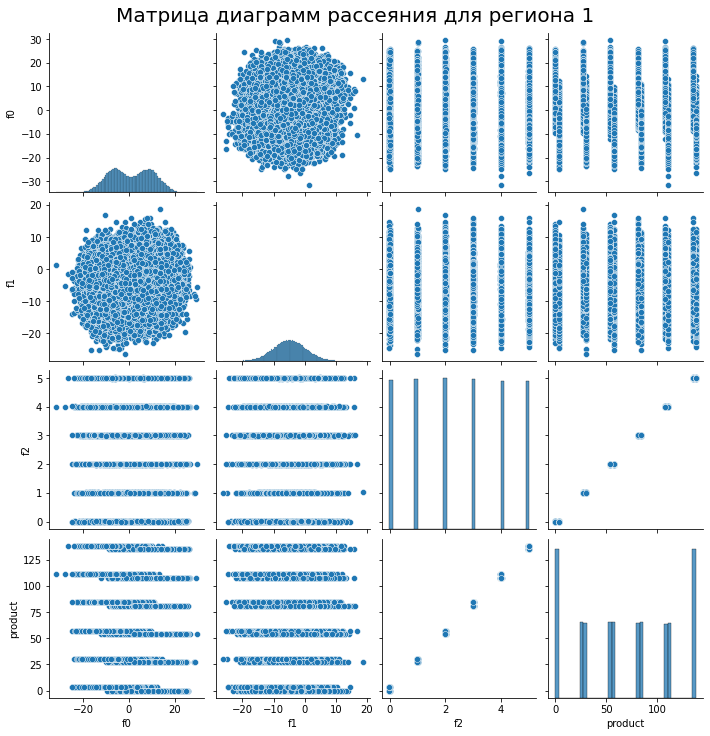

In [40]:
g = sns.pairplot(geo_data_1, palette=('#FFFF00', '#800080'))
g.fig.suptitle('Матрица диаграмм рассеяния для региона 1', y=1.02, fontsize= 20)
plt.show()

- Действительно `f2` и `product` очень сильно связаны прямой связью
- Для второго региона характерны дискретные значения признаков `f2` и `product`

#### Корреляционный анализ `geo_data_2`

In [41]:
geo_data_2.corr(method='spearman').style.background_gradient(cmap = 'coolwarm')

,f0,f1,f2,product
f0,1.000000,0.002465,0.000041,-0.002445
f1,0.002465,1.000000,0.000364,-0.001493
f2,0.000041,0.000364,1.000000,0.448467
product,-0.002445,-0.001493,0.448467,1.000000


Целевой признак `product` коррелирует только с признаком `f2`. Отальные признаки друг с другом никак не коррелируют

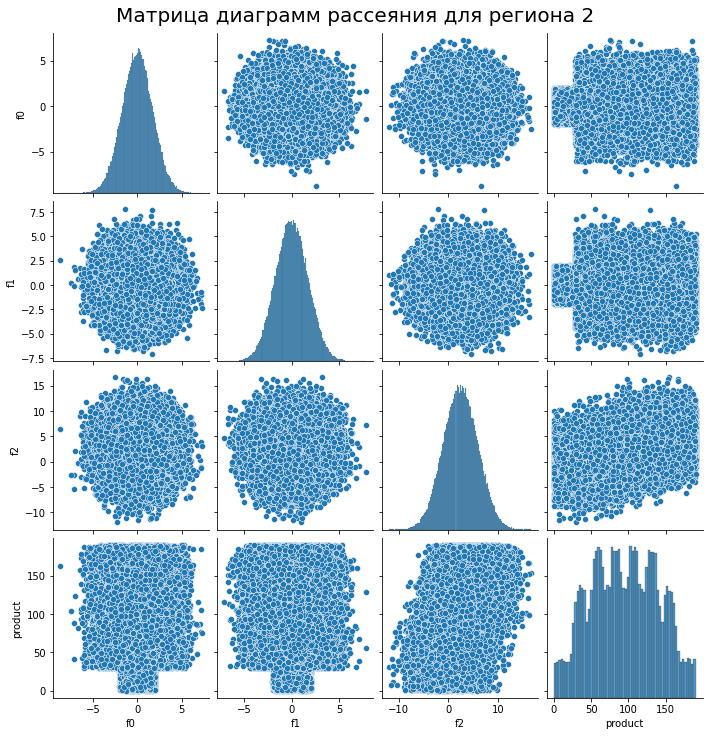

In [42]:
g = sns.pairplot(geo_data_2, palette=('#FFFF00', '#800080'))
g.fig.suptitle('Матрица диаграмм рассеяния для региона 2', y=1.02, fontsize= 20)
plt.show()

- Очень интересная форма получилась на диаграмме рассеяния входных признаков `f0` и `f1` c целевым признаком `product`. Много прямых углов, симметрия и похожие как две капли воды формы обеих диаграмм рассеяния
- Связь между целевым признаком `product` и входным `f2` все также хорошо видна на диагрмме рассеяния
- Остальные пары признаков никак не коррелируют между собой

**Вывод по разделу `Корреляционный анализ`**

- Входные признаки у всех трех датасетов очень слабо коррелирую между собой, что является положительным фактором для модели линейной регрессии. Однако целевой признак существенно коррелирует только с одним входным признаком `f2`. С остальными корреляции по Спирману вообще не наблюдается.
- Также были построены диаграммы рассеяния, некоторые из которых удивили своей правильной и симметричной формой. Например пара `product` и `f0` или `f1`(у региона 2). В также `f1` и  `f0` (у региона 0)

## Обучение и проверка модели

Для предсказания запасов скважины по заданию можно использовать только линейную регрессию. Разобьем все три датасета на тренировочную и валидационную выборки и обучим три модели линейной регрессии. Линейной регрессии не нужно масштабирование числовых данных, а категориальные данные у нас отсутствуют

In [43]:

RANDOM_STATE = 42



def split_and_fit(dataset):
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('product', axis = 1), dataset['product'],\
                                                        test_size = 0.25, random_state = RANDOM_STATE)
    
    model = LinearRegression(n_jobs = -1)
    
    model.fit(X_train, y_train)
    y_pred =  model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    mean_reserve = y_pred.mean()
    

    print('RMSE модели','-'*13,  round(rmse, 4))
    print('Средний запас сырья ', '-'*4, round(mean_reserve,4))
    
    return model, X_train, X_test, y_train, y_test, y_pred 



model_0, X_train_0, X_test_0, y_train_0, y_test_0, y_pred_0 = split_and_fit(geo_data_0)


RMSE модели ------------- 37.7611
Средний запас сырья  ---- 92.2865


**Обучим вторую модель:**

In [44]:
model_1, X_train_1, X_test_1, y_train_1, y_test_1, y_pred_1 = split_and_fit(geo_data_1)

RMSE модели ------------- 0.8929
Средний запас сырья  ---- 69.1689


**Обучим третью модель:**

In [45]:
model_2, X_train_2, X_test_2, y_train_2, y_test_2, y_pred_2 = split_and_fit(geo_data_2)

RMSE модели ------------- 40.1312
Средний запас сырья  ---- 94.8207


**Вывод по разделу `Обучение и проверка модели`**

В качестве модели для прогноза была выбрана Линейная регрессия, поскольку другие модели не так просты для понимания. Всего было обучено три модели. Первая модель - для нулевого региона. Вторая модель - для первого региона и третья модель - для второго региона. 
- Наименьшим отклонением (корень из среднего квадратичного отклонения) обладает модель, обученная на данных по первому региону. То есть эта модель намного точнее остальных предсказывала запасы скважин на валидационной выборке. Однако, согласно предсказаниям этой модели, в первом регионе самое низкое число средних запасов скважин (69)
- Наибольшим средним запасом скважин обладает второй регион (94.8), однако модель соответсвующая этому региону имеет самое высокое среднее отклонение (40)
- Нулевой регион имеет немного меньшие средние запасы (92.3) и отклонение (37.8)

## Подготовка к расчёту прибыли

In [46]:
#всего точек для рассмотрения
TOTAL_POINTS = 500

#нужно отобрать 200 точек
SELECTED_POINTS = 200

#бюджет
BUDGET = 10_000_000_000

#цена за 1 ед продукции(1 тыс баррелей)
PRICE = 450_000

#вероятность убытков должна быть ниже:
PROBABILITY = 0.025



#достаточный объем сырья для безубыточной разработки новой скважины:
required_reserve = BUDGET/(PRICE*SELECTED_POINTS)
print('Достаточный объем сырья для безубыточной разработки новой скважины - ', round(required_reserve, 2), 'тыс.баррелей')

Достаточный объем сырья для безубыточной разработки новой скважины -  111.11 тыс.баррелей


- Средний запас сырья `нулевого региона`  ---- 92.2865
- Средний запас сырья `первого региона` ------ 69.1689
- Средний запас сырья `второго региона` ------ 94.8207

**Вывод по разделу `Подготовка к расчету прибыли`**

Данные, необходимые для расчетов, были сохранены в отдельные переменные. Также был расчитан необходимый для безубыточной разработки объем скважины. Согласно спрогнозированным значениям запасов скважин, ни один регион не имеет средних запасов, которые бы достигали необходимого безубыточного значения (111.11 тыс баррелей). Это значит, что заказчику нужно искать тщательно искать скважины, имеющие запасы выше среднего и таких скважин может оказаться совсем немного

## Расчёт прибыли и рисков 

**Посчитаем прибыль от разработки скважин в каждом регионе. Методами машинного обучения в каждом регионе выбираются 200 лучших скважин. Затем исходя из продуктивности выбранных скважин подсчитывается прибыль от работ в этом регионе**

In [47]:
y_pred_0 = pd.Series(y_pred_0, y_test_0.index)
y_pred_1 = pd.Series(y_pred_1, y_test_1.index)
y_pred_2 = pd.Series(y_pred_2, y_test_2.index)

In [48]:
#функция для расчета прибыли от региона, выбранного для разработки. 
#В регионе методом машинного обучения выбираются 200 лучших скважин
def count_profit(y_test, y_pred):
    
    y_test = y_test.reset_index(drop= True)
    y_pred = y_pred.reset_index(drop = True)
    

    #сортируем по убыванию предсказанной продуктивности
    y_pred_sorted = y_pred.sort_values(ascending = False)
    #отбираем 200 лучших
    y_pred_selected = y_pred_sorted.head(SELECTED_POINTS)
    #берем целевое значение из тестовой выборки
    production = y_test.loc[y_pred_selected.index]
    #подсчет прибыли
    profit = PRICE*sum(production) - BUDGET
    #print(len(production))
    #print(sum(production)*price)
    return profit

In [49]:
print('Прибыль в нулевом регионе: ', round(count_profit(y_test_0, y_pred_0),2))
print('Прибыль в первом регионе: ', round(count_profit(y_test_1, y_pred_1),2))
print('Прибыль во втором регионе: ', round(count_profit(y_test_2, y_pred_2),2))


Прибыль в нулевом регионе:  3301821343.65
Прибыль в первом регионе:  2415086696.68
Прибыль во втором регионе:  2103914701.3


**Проведем оценку рисков при выборе одного из трех регионов для разработки. 1000 раз случайно сформируем выборки по 500 скважин, из которых отберем 200 лучших по предсказанным моделью запасам, и для этих 200 скважин считаем прибыль. Таким образом получим 1000 разных ситуаций и 1000 разных прибылей, что позволит нам оценить распределение истинной прибыли**

In [50]:
def risk_evaluation(y_test, y_pred):
    
    state = np.random.RandomState(12345)
    profit_distr = []
    for i in range(1000):
        y_test_sample = y_test.sample(random_state = state, n = TOTAL_POINTS, replace = True )
        y_pred_sample = y_pred.loc[y_test_sample.index]
        
        
        #применение функции подсчета прибыли
        profit = count_profit(y_test_sample, y_pred_sample)
        profit_distr.append(profit)

            
            
    profit_distr = pd.Series(profit_distr)
    print('Средняя прибыль :', round(profit_distr.mean(), 2))

    lower = profit_distr.quantile(0.025)
    upper = profit_distr.quantile(0.975)
    print(f'95% доверительный интервал для прибыли - [{round(lower, 2)}, {round(upper, 2)}]')

    print('Риск убытков составляет -', round((profit_distr < 0).mean() * 100, 4), '%')

    warnings.filterwarnings('ignore')
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(1,2,figsize=(18,5))
    sns.histplot(profit_distr, bins=20, kde=True, ax = ax[0])
    ax[0].set_title('Гистограмма прибыли')
    ax[0].set_ylabel('Кол-во наблюдений')
    ax[0].set_xlabel('Значения прибыли')

    sns.boxplot(profit_distr, ax= ax[1], width = 0.2)
    ax[1].set_title('Диаграмма размаха прибыли')
    ax[1].set_xlabel('Значения прибыли')
    plt.show()
    
    #print(profit_distr)
    

**Оценка рисков в нулевом регионе:**

Средняя прибыль : 396713209.98
95% доверительный интервал для прибыли - [-101791405.46, 931564037.52]
Риск убытков составляет - 7.2 %


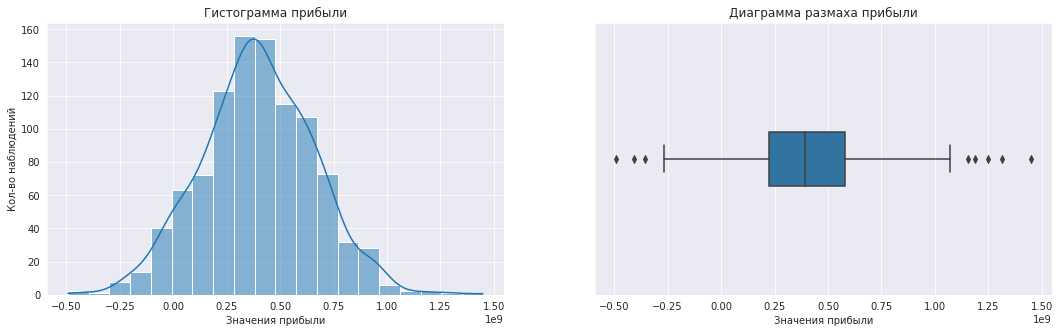

In [51]:
risk_evaluation(y_test_0, y_pred_0)

**Оценка рисков в первом регионе:**

Средняя прибыль : 488472615.6
95% доверительный интервал для прибыли - [90888856.31, 894380080.96]
Риск убытков составляет - 1.0 %


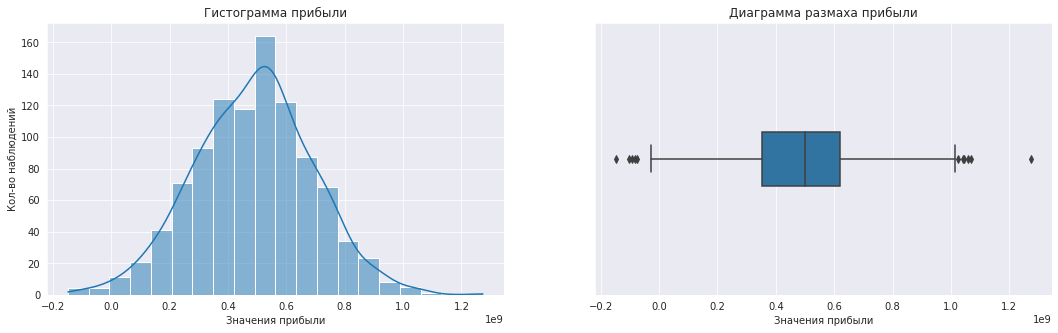

In [52]:
risk_evaluation(y_test_1, y_pred_1)

**Оценка рисков во втором регионе:**

Средняя прибыль : 357474160.79
95% доверительный интервал для прибыли - [-120489907.85, 897140764.49]
Риск убытков составляет - 7.3 %


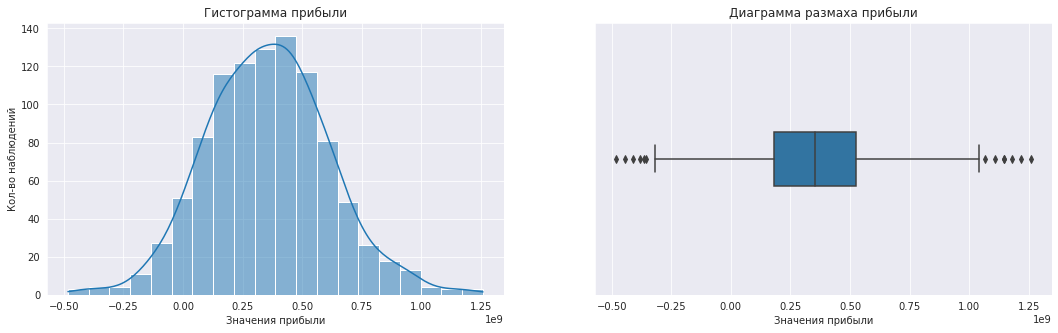

In [53]:
risk_evaluation(y_test_2, y_pred_2)

**Вывод по разделу `Расчет прибыли и рисков`**

В каждом регионе при помощи линейной регрессии были отобраны 200 лучших скважин и посчитана прибыль от их разработки:

- Прибыль в нулевом регионе:  3301821343.65
- Прибыль в первом регионе:  2415086696.68
- Прибыль во втором регионе:  2103914701.3

Согласно расчетам, для безубыточной разработки новой скважины, нужно чтобы ее запасы составляли 111.11 тыс баррелей и более. Однако во всех трех регионах средний запас скважин меньше:
- Средний запас сырья нулевого региона ---- 92.2865
- Средний запас сырья первого региона ------ 69.1689
- Средний запас сырья второго региона ------ 94.8207

Значит скважины нужно отбирать тщательно, если не хотим терпеть убытки.


При оценке рисков, для каждого региона была сформирована одна тысяча выборок по 500 скважин. Среди этих 500 скважин, при помощи линейной регрессии были отобораны 200 лучших по запасам и для отобранных скважин подсчитана прибыль. Благодаря сформированному таким образом распределению прибыли, можно оценить доверительный интервал прибыли, среднюю прибыль, а также риск убытков. 

Согласно произведенным оценкам, наиболее привлекательным для разработки является регион 1, поскольку он единственный удовлетворяет требованию о риске убытков менее 2.5%. Кроме того, первый регион обладает наибольшей средней прибылью, а также это единственный регион, у которого в 95% доверительном интервале нет отрицательных значений прибыли. Оно и понятно, ведь в этом регионе риск убытков составляет всего 1%


## Общий вывод

Задачей проекта был выбор региона для разработки и  построение модели, отбирающей 200 лучших скважин. В результате проекта был выбран регион номер 1, поскольку при оценке рисков, только этот регин показал достаточно низкую веротность убытков 1%. Кроме того, согласно оценкам, скважины отобранные моделью из этого региона имеют наибольшую среднюю прибыль по сравнению с другими регионами